In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import folium 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Data Preparation

#### Scrape wiki to get the table for Atlanta Neighborhood and their population and build the dataframe

In [2]:
data_src = requests.get('https://en.wikipedia.org/wiki/Table_of_Atlanta_neighborhoods_by_population').text
soup = BeautifulSoup(data_src, 'lxml')
table = soup.find('table', class_='wikitable sortable')

#print(table)

Neighborhood = []
Population = []

for row in table.find_all('tr') [1:]:
    Neighborhood.append(str(row.find_all('td')[0].text.strip('\n')))
    Population.append(str(row.find_all('td')[1].text.strip('\n')))

    
cols = {'Neighborhood': Neighborhood,'Population': Population}
df_wiki = pd.DataFrame(cols)

df_wiki['Neighborhood'] = pd.DataFrame(df_wiki['Neighborhood'].apply (lambda x: x+', GA, USA'))
df_wiki['Population'] = pd.DataFrame(df_wiki['Population'].apply (lambda x: int(x.replace(',',''))))

df_wiki['Neighborhood'] = df_wiki['Neighborhood'].replace('Downtown, GA, USA','Atlanta Downtown, GA, USA')
#df_wiki['Neighborhood'] = df_wiki['Neighborhood'].replace('Custer/McDonough/Guice','Custer')

#(pd.to_numeric(df_wiki['Population'])>5000) &
df_wiki = df_wiki[ (df_wiki['Neighborhood']!='Fairburn Mays, GA, USA')\
                  & (df_wiki['Neighborhood']!='Betmar LaVilla, GA, USA') \
                  & (df_wiki['Neighborhood']!='Custer/McDonough/Guice, GA, USA') \
                  & (df_wiki['Neighborhood']!='Knight Park/Howell Station, GA, USA') \
                  & (df_wiki['Neighborhood']!='Marietta Street Artery, GA, USA') \
                  & (df_wiki['Neighborhood']!='Lindridge/Martin Manor, GA, USA') \
                  & (df_wiki['Neighborhood']!='Morningside/Lenox Park, GA, USA')]

df_wiki=df_wiki.reset_index(drop=True)

#df_wiki.info


print(df_wiki.shape)
df_wiki.head()

#df_wiki.to_csv("Atl_neighborhood.csv")

(154, 2)


,Neighborhood,Population
0,"Adair Park, GA, USA",1331
1,"Adams Park, GA, USA",1763
2,"Adamsville, GA, USA",2403
3,"Almond Park, GA, USA",1020
4,"Ansley Park, GA, USA",2277


In [3]:
#df_wiki['Neighborhood'] = pd.DataFrame(df_wiki['Neighborhood'].apply (lambda x: x.replace(', GA','')))
df_wiki.describe()
#df_wiki.dtypes

,Population
count,154.000000
mean,2356.863636
std,2278.434264
min,501.000000
25%,938.500000
50%,1731.500000
75%,2773.500000
max,16569.000000


In [4]:
df_populated = df_wiki.sort_values('Population', ascending = False).reset_index(drop=True)[0:15]
df_populated

,Neighborhood,Population
0,"Midtown, GA, USA",16569
1,"Atlanta Downtown, GA, USA",13411
2,"Old Fourth Ward, GA, USA",10505
3,"North Buckhead, GA, USA",8270
4,"Pine Hills, GA, USA",8033
5,"Virginia-Highland, GA, USA",7800
6,"Grant Park, GA, USA",6771
7,"Georgia Tech, GA, USA",6607
8,"Kirkwood, GA, USA",5897
9,"Atlanta University Center, GA, USA",5703


#### Get the coordinates for Atlanta

In [5]:
address = 'Atlanta, GA'

geolocator = Nominatim(user_agent="atlanta_explorer")
location = geolocator.geocode(address)
atl_latitude = location.latitude
atl_longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, atl_latitude, atl_longitude))

The geograpical coordinate of Atlanta, GA are 33.7490987, -84.3901849.


#### Get the coordinates of each Neighborhood

In [6]:
geolocator = Nominatim(user_agent="atlanta_explorer")
df_populated['Lat'] = df_populated['Neighborhood'].apply(geolocator.geocode).apply(lambda x: (x.latitude))
df_populated['Lng'] = df_populated['Neighborhood'].apply(geolocator.geocode).apply(lambda x: (x.longitude))
df_populated['Neighborhood'] = pd.DataFrame(df_populated['Neighborhood'].apply (lambda x: x.replace(', GA, USA','')))


df_populated
#df_wiki.to_csv('Atl_neighborhood.csv')

,Neighborhood,Population,Lat,Lng
0,Midtown,16569,33.781127,-84.386360
1,Atlanta Downtown,13411,33.748309,-84.392118
2,Old Fourth Ward,10505,35.231254,-80.843405
3,North Buckhead,8270,33.839814,-84.379559
4,Pine Hills,8033,33.360950,-84.834658
5,Virginia-Highland,7800,33.782656,-84.353691
6,Grant Park,6771,33.735862,-84.370932
7,Georgia Tech,6607,33.776033,-84.398841
8,Kirkwood,5897,33.756217,-84.323258
9,Atlanta University Center,5703,33.751543,-84.413597


In [7]:
df_populated.at[2,'Lat'] = 33.7640
df_populated.at[2,'Lng'] = -84.3720
df_populated.at[4,'Lat'] = 33.8375
df_populated.at[4,'Lng'] = -84.3516
df_populated.at[12,'Lat'] = 33.7862
df_populated.at[12,'Lng'] = -84.4019
df_populated.at[14,'Lat'] = 33.8363
df_populated.at[14,'Lng'] = -84.3878
#['Lat'] = pd.to_numeric(df_wiki['Lat'].replace(33.360950,33.8375))

#df_wiki.to_csv('Atl_neighborhood.csv')

df_populated


,Neighborhood,Population,Lat,Lng
0,Midtown,16569,33.781127,-84.386360
1,Atlanta Downtown,13411,33.748309,-84.392118
2,Old Fourth Ward,10505,33.764000,-84.372000
3,North Buckhead,8270,33.839814,-84.379559
4,Pine Hills,8033,33.837500,-84.351600
5,Virginia-Highland,7800,33.782656,-84.353691
6,Grant Park,6771,33.735862,-84.370932
7,Georgia Tech,6607,33.776033,-84.398841
8,Kirkwood,5897,33.756217,-84.323258
9,Atlanta University Center,5703,33.751543,-84.413597


In [8]:
map_atl = folium.Map(location=[atl_latitude, atl_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_populated['Lat'], df_populated['Lng'], df_populated['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='indigo',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        
        parse_html=False).add_to(map_atl)  
    
map_atl.save('images/Cluster_map.html')
map_atl



#### Get the venues in each neighborhood using Foursquare API

In [9]:
CLIENT_ID = 'L4F5HK0VMJ113WPWH505FE3QP0QXFVSJX5EIAVLH4JJKNTDK' # your Foursquare ID
CLIENT_SECRET = 'BF3GM3RV1PH2GBZHV5YSVVOGMRPJ4PVNMBOQEPXPL1F0MECY' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

In [10]:
#Get all venues details
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
df_atl_venues_all = getNearbyVenues(names=df_populated['Neighborhood'],
                                   latitudes=df_populated['Lat'],
                                   longitudes=df_populated['Lng']
                                  )


df_atl_venues_all.to_csv('Atl_all_venues.csv')

In [12]:
df_atl_venues_all.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Midtown,33.781127,-84.38636,Cafe Agora,33.780932,-84.384460,Mediterranean Restaurant
1,Midtown,33.781127,-84.38636,Mac's Beer & Wine,33.780916,-84.387992,Liquor Store
2,Midtown,33.781127,-84.38636,Savi Provisions,33.781010,-84.384278,Gourmet Shop
3,Midtown,33.781127,-84.38636,Dancing Goats Coffee Bar,33.780810,-84.386653,Coffee Shop
4,Midtown,33.781127,-84.38636,Brazilian Wax by Andreia,33.780646,-84.387739,Spa


#### Get the category-tree using Foursquare API

In [13]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

results_cat = requests.get(url).json()
df_category = pd.DataFrame(columns=['type','id','name'])

for cat_type in results_cat['response'].get('categories'):    
    df_tmp = pd.DataFrame(columns=['type','id','name'])
    json_cat = json_normalize(cat_type.get('categories'))    
    df_tmp['id'] = json_cat['id']
    df_tmp['name'] = json_cat['name']
    df_tmp['type'] = cat_type.get('name')
    df_category = df_category.append(df_tmp)
    
    sub_cat = json_cat['categories']
    for sub_cat_type in sub_cat:     
        if len(sub_cat_type)>0:
            df_tmp = pd.DataFrame(columns=['type','id','name'])
            json_sub_cat = json_normalize(sub_cat_type)
            df_tmp['id'] = json_sub_cat['id']
            df_tmp['name'] = json_sub_cat['name']
            df_tmp['type'] = cat_type.get('name')
            df_category = df_category.append(df_tmp)
    
#df_category.set_index('type', inplace=True)
#df_category.to_csv('categories.csv', index=False)
df_category.rename(columns={"name":"Venue Category","type":"Parent Category"}, inplace=True)
df_category.head()

,Parent Category,id,Venue Category
0,Arts & Entertainment,56aa371be4b08b9a8d5734db,Amphitheater
1,Arts & Entertainment,4fceea171983d5d06c3e9823,Aquarium
2,Arts & Entertainment,4bf58dd8d48988d1e1931735,Arcade
3,Arts & Entertainment,4bf58dd8d48988d1e2931735,Art Gallery
4,Arts & Entertainment,4bf58dd8d48988d1e4931735,Bowling Alley


# Methodology

#### Merge the datasets  (df_atl_venues_all & df_category) to create a final dataset having the rolled up Category of each venue and cleanup the dataset to remove the unwanted column (id).

In [14]:
df_atlanta = df_atl_venues_all.merge(df_category, on='Venue Category', how='left')
df_atlanta.drop(['id'], axis = 1, inplace=True)
#df_atlanta['Neighborhood'].value_counts()
df_atlanta.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Parent Category
0,Midtown,33.781127,-84.38636,Cafe Agora,33.780932,-84.384460,Mediterranean Restaurant,Food
1,Midtown,33.781127,-84.38636,Mac's Beer & Wine,33.780916,-84.387992,Liquor Store,Shop & Service
2,Midtown,33.781127,-84.38636,Savi Provisions,33.781010,-84.384278,Gourmet Shop,Shop & Service
3,Midtown,33.781127,-84.38636,Dancing Goats Coffee Bar,33.780810,-84.386653,Coffee Shop,Food
4,Midtown,33.781127,-84.38636,Brazilian Wax by Andreia,33.780646,-84.387739,Spa,Shop & Service


#### Select only the venues that are of Category 'Food'

In [15]:
df_atlanta_1 = df_atlanta[df_atlanta['Parent Category'] == 'Food'].reset_index(drop=True)
print(df_atlanta_1.shape)
df_atlanta_1.head()

(172, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Parent Category
0,Midtown,33.781127,-84.38636,Cafe Agora,33.780932,-84.384460,Mediterranean Restaurant,Food
1,Midtown,33.781127,-84.38636,Dancing Goats Coffee Bar,33.780810,-84.386653,Coffee Shop,Food
2,Midtown,33.781127,-84.38636,Sweet Hut Bakery & Cafe,33.780315,-84.384100,Bakery,Food
3,Midtown,33.781127,-84.38636,Marlow's Tavern,33.780110,-84.387566,New American Restaurant,Food
4,Midtown,33.781127,-84.38636,Ecco Midtown,33.778827,-84.385988,Mediterranean Restaurant,Food


#### Apply Onehot encoding on the Venue Category

Each neighborhood is analyzed individually to understand the most common cuisine being served within its 500 meters of the vicinity.
The above process is taken forth by using ‘one hot encoding’ function of python ‘pandas’ library. One hot encoding converts the categorical variables (which are ‘Venue Category’) into a form that could be provided to ML algorithms to do a better job in prediction.

In [16]:
# one hot encoding
df_atlanta_onehot_food = pd.get_dummies(df_atlanta_1[['Venue Category']], prefix="", prefix_sep="")


# add neighborhood column back to dataframe
df_atlanta_onehot_food['Neighborhood'] = df_atlanta_1['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [df_atlanta_onehot_food.columns[-1]] + list(df_atlanta_onehot_food.columns[:-1])
df_atlanta_onehot_food = df_atlanta_onehot_food[fixed_columns].reset_index(drop=True)
print(df_atlanta_onehot_food.shape)
df_atlanta_onehot_food.head(10)

(172, 51)


,Neighborhood,American Restaurant,BBQ Joint,Bagel Shop,Bakery,Breakfast Spot,Buffet,Burger Joint,Café,Caribbean Restaurant,...,Seafood Restaurant,Snack Place,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Taco Place,Tapas Restaurant,Turkish Restaurant,Vietnamese Restaurant,Wings Joint
0,Midtown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Midtown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Midtown,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Midtown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Midtown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Midtown,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,Midtown,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,Midtown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Midtown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Midtown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Group by the Neighborhoods to find out the total number of Venue categories in each neighborhood

In [17]:
df_atl_food = df_atlanta_onehot_food.groupby('Neighborhood').sum().reset_index()
df_atl_food = df_atl_food.merge(df_populated, on='Neighborhood', how='left')
df_atl_food = df_atl_food.drop(['Restaurant'], axis = 1)

df_atl_food

,Neighborhood,American Restaurant,BBQ Joint,Bagel Shop,Bakery,Breakfast Spot,Buffet,Burger Joint,Café,Caribbean Restaurant,...,Spanish Restaurant,Steakhouse,Taco Place,Tapas Restaurant,Turkish Restaurant,Vietnamese Restaurant,Wings Joint,Population,Lat,Lng
0,Atlanta Downtown,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,13411,33.748309,-84.392118
1,Atlanta University Center,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,5703,33.751543,-84.413597
2,East Atlanta,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,2,0,5033,33.740106,-84.344925
3,Georgia Tech,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6607,33.776033,-84.398841
4,Grant Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6771,33.735862,-84.370932
5,Grove Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,4929,33.773440,-84.445485
6,Home Park,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4941,33.786200,-84.401900
7,Kirkwood,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5897,33.756217,-84.323258
8,Midtown,5,0,0,2,1,0,1,2,0,...,0,1,2,1,0,2,1,16569,33.781127,-84.386360
9,North Buckhead,2,0,0,1,0,0,1,1,0,...,1,2,0,1,1,0,0,8270,33.839814,-84.379559


#### Find out the top-5 restaurant categories in Atlanta

In [18]:
df_describe = df_atl_food.describe().transpose()
top5_venues = df_describe.sort_values('max', ascending = False)[2:7]
top5_venues

,count,mean,std,min,25%,50%,75%,max
American Restaurant,13.0,0.692308,1.436698,0.0,0.0,0.0,1.0,5.0
Seafood Restaurant,13.0,0.461538,0.877058,0.0,0.0,0.0,1.0,3.0
Sandwich Place,13.0,0.769231,1.012739,0.0,0.0,0.0,1.0,3.0
Mediterranean Restaurant,13.0,0.384615,0.869718,0.0,0.0,0.0,0.0,3.0
Gastropub,13.0,0.384615,0.767948,0.0,0.0,0.0,0.0,2.0


In [19]:
columns = ['Neighborhood']

for i in top5_venues.index:
    columns = columns + [i]

columns

['Neighborhood',
 'American Restaurant',
 'Seafood Restaurant',
 'Sandwich Place',
 'Mediterranean Restaurant',
 'Gastropub']

In [20]:
df_atl_food_top = df_atl_food[columns]
df_atl_top_copy = df_atl_food_top.copy()
df_atl_food_top

,Neighborhood,American Restaurant,Seafood Restaurant,Sandwich Place,Mediterranean Restaurant,Gastropub
0,Atlanta Downtown,1,0,2,0,0
1,Atlanta University Center,0,0,1,0,0
2,East Atlanta,0,1,0,0,2
3,Georgia Tech,0,0,1,0,0
4,Grant Park,0,0,0,0,0
5,Grove Park,0,1,0,0,0
6,Home Park,0,0,2,1,0
7,Kirkwood,0,0,0,0,0
8,Midtown,5,3,3,3,1
9,North Buckhead,2,1,0,1,2


#### Top 5 restaurant categories are further plotted individually on bar graph for each neighborhood

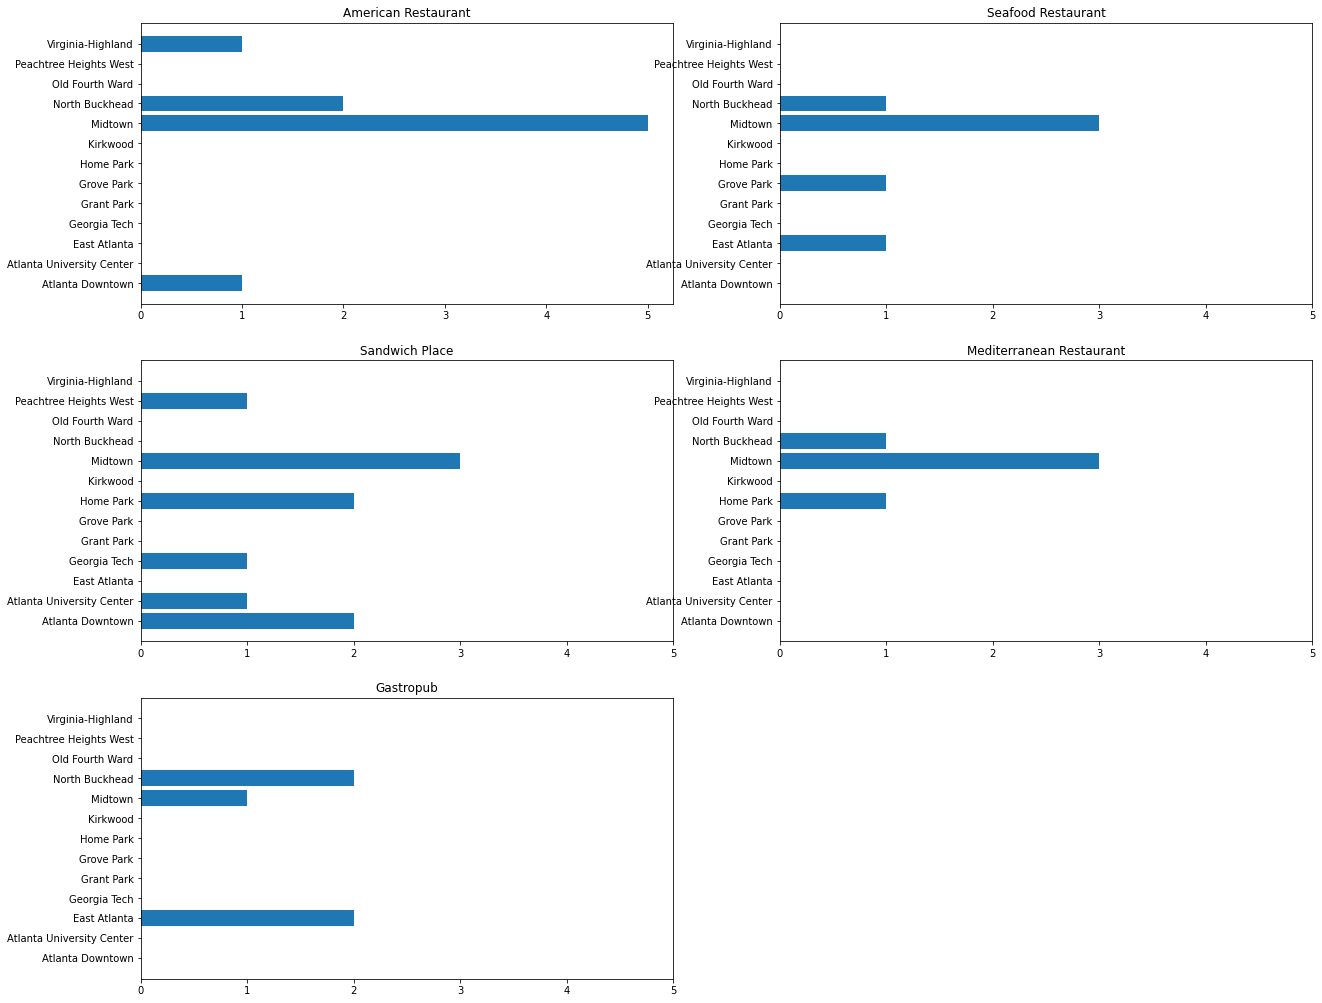

In [21]:
plt.subplots(figsize=(21,30))

xticks = [0,1,2,3,4,5]
i=1
for c in columns[1:]:
    plt.subplot(5,2,i)
    plt.barh(df_atl_food_top['Neighborhood'], df_atl_food_top[c])
    plt.title(c)
    #plt.ylabel('No. of Venues')
    plt.xticks(xticks)
    #plt.yticks(yticks)
    i = i+1

plt.savefig('images/top5_foodcat_locationwise.png')
plt.show()

#### Explore the nearby tourist and other venues in the neighborhoods

In [22]:
# one hot encoding
df_atlanta_onehot = pd.get_dummies(df_atlanta[['Parent Category']], prefix="", prefix_sep="")


# add neighborhood column back to dataframe
df_atlanta_onehot['Neighborhood'] = df_atlanta['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [df_atlanta_onehot.columns[-1]] + list(df_atlanta_onehot.columns[:-1])
df_atlanta_onehot = df_atlanta_onehot[fixed_columns]

df_atlanta_onehot.head()

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Midtown,0,0,1,0,0,0,0,0
1,Midtown,0,0,0,0,0,0,1,0
2,Midtown,0,0,0,0,0,0,1,0
3,Midtown,0,0,1,0,0,0,0,0
4,Midtown,0,0,0,0,0,0,1,0


In [23]:
df_atl_other_venues = df_atlanta_onehot.groupby('Neighborhood').sum().reset_index()
df_atl_other_venues = df_atl_other_venues.merge(df_populated, on='Neighborhood', how='left')
df_atl_other_venues

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population,Lat,Lng
0,Atlanta Downtown,2,0,9,4,0,0,1,4,13411,33.748309,-84.392118
1,Atlanta University Center,0,0,5,1,0,0,2,1,5703,33.751543,-84.413597
2,Collier Heights,0,0,0,0,1,0,0,0,5593,33.769829,-84.507154
3,East Atlanta,3,0,17,11,2,0,7,0,5033,33.740106,-84.344925
4,Georgia Tech,1,2,7,0,1,0,1,0,6607,33.776033,-84.398841
5,Grant Park,22,0,5,1,10,0,4,1,6771,33.735862,-84.370932
6,Grove Park,0,0,3,0,3,0,3,1,4929,33.773440,-84.445485
7,Home Park,2,0,16,1,1,0,4,0,4941,33.786200,-84.401900
8,Kirkwood,0,0,3,0,3,0,0,0,5897,33.756217,-84.323258
9,Midtown,4,0,54,7,3,1,19,6,16569,33.781127,-84.386360


#### Overall correlation of Food with other venues

In [24]:
df_atl_all_venues = df_atl_other_venues.merge(df_atl_food_top, on='Neighborhood', how='left')
df_atl_all_venues.dropna(how="any", inplace = True)
df_atl_all_venues

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population,Lat,Lng,American Restaurant,Seafood Restaurant,Sandwich Place,Mediterranean Restaurant,Gastropub
0,Atlanta Downtown,2,0,9,4,0,0,1,4,13411,33.748309,-84.392118,1.0,0.0,2.0,0.0,0.0
1,Atlanta University Center,0,0,5,1,0,0,2,1,5703,33.751543,-84.413597,0.0,0.0,1.0,0.0,0.0
3,East Atlanta,3,0,17,11,2,0,7,0,5033,33.740106,-84.344925,0.0,1.0,0.0,0.0,2.0
4,Georgia Tech,1,2,7,0,1,0,1,0,6607,33.776033,-84.398841,0.0,0.0,1.0,0.0,0.0
5,Grant Park,22,0,5,1,10,0,4,1,6771,33.735862,-84.370932,0.0,0.0,0.0,0.0,0.0
6,Grove Park,0,0,3,0,3,0,3,1,4929,33.773440,-84.445485,0.0,1.0,0.0,0.0,0.0
7,Home Park,2,0,16,1,1,0,4,0,4941,33.786200,-84.401900,0.0,0.0,2.0,1.0,0.0
8,Kirkwood,0,0,3,0,3,0,0,0,5897,33.756217,-84.323258,0.0,0.0,0.0,0.0,0.0
9,Midtown,4,0,54,7,3,1,19,6,16569,33.781127,-84.386360,5.0,3.0,3.0,3.0,1.0
10,North Buckhead,0,0,30,2,1,0,10,1,8270,33.839814,-84.379559,2.0,1.0,0.0,1.0,2.0


#### Find out correlation of each type of restaurant cuisine types

In [25]:
cols = ['Neighborhood', 'Nightlife Spot','Professional & Other Places', 'Shop & Service', 'Travel & Transport']\
        + columns[1:] + ['Population', 'Lat', 'Lng']

df_atl_corr_venues = df_atl_all_venues[cols]
df_atl_corr_venues

,Neighborhood,Nightlife Spot,Professional & Other Places,Shop & Service,Travel & Transport,American Restaurant,Seafood Restaurant,Sandwich Place,Mediterranean Restaurant,Gastropub,Population,Lat,Lng
0,Atlanta Downtown,4,0,1,4,1.0,0.0,2.0,0.0,0.0,13411,33.748309,-84.392118
1,Atlanta University Center,1,0,2,1,0.0,0.0,1.0,0.0,0.0,5703,33.751543,-84.413597
3,East Atlanta,11,0,7,0,0.0,1.0,0.0,0.0,2.0,5033,33.740106,-84.344925
4,Georgia Tech,0,0,1,0,0.0,0.0,1.0,0.0,0.0,6607,33.776033,-84.398841
5,Grant Park,1,0,4,1,0.0,0.0,0.0,0.0,0.0,6771,33.735862,-84.370932
6,Grove Park,0,0,3,1,0.0,1.0,0.0,0.0,0.0,4929,33.773440,-84.445485
7,Home Park,1,0,4,0,0.0,0.0,2.0,1.0,0.0,4941,33.786200,-84.401900
8,Kirkwood,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5897,33.756217,-84.323258
9,Midtown,7,1,19,6,5.0,3.0,3.0,3.0,1.0,16569,33.781127,-84.386360
10,North Buckhead,2,0,10,1,2.0,1.0,0.0,1.0,2.0,8270,33.839814,-84.379559


#### Correlation map

In [26]:
df_atl_all_venues.corr()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population,Lat,Lng,American Restaurant,Seafood Restaurant,Sandwich Place,Mediterranean Restaurant,Gastropub
Arts & Entertainment,1.000000,-0.089822,-0.031490,0.018125,0.906479,0.062485,-0.032671,0.116133,0.033449,-0.394996,0.124806,-0.028648,-0.025934,-0.079144,0.002491,-0.070521
College & University,-0.089822,1.000000,-0.129592,-0.217130,-0.123091,-0.083333,-0.254869,-0.175219,-0.097014,0.011966,-0.158632,-0.144785,-0.158114,0.068465,-0.132874,-0.150482
Food,-0.031490,-0.129592,1.000000,0.556514,-0.057561,0.847949,0.729950,0.680250,0.636117,0.305816,0.047285,0.935217,0.872230,0.556453,0.940815,0.614798
Nightlife Spot,0.018125,-0.217130,0.556514,1.000000,-0.097362,0.400334,0.494396,0.364828,0.327480,-0.243083,0.355314,0.440121,0.536426,0.178391,0.328900,0.659203
Outdoors & Recreation,0.906479,-0.123091,-0.057561,-0.097362,1.000000,0.105507,-0.088580,0.050179,-0.040278,-0.371163,0.148824,-0.037341,0.091752,-0.243194,0.022431,-0.057157
Professional & Other Places,0.062485,-0.083333,0.847949,0.400334,0.105507,1.000000,0.622181,0.801002,0.723514,0.059077,-0.038621,0.900885,0.869626,0.661831,0.903540,0.240772
Shop & Service,-0.032671,-0.254869,0.729950,0.494396,-0.088580,0.622181,1.000000,0.364207,0.363945,0.494333,0.136802,0.714149,0.610402,0.262772,0.619139,0.384436
Travel & Transport,0.116133,-0.175219,0.680250,0.364828,0.050179,0.801002,0.364207,1.000000,0.862747,-0.091230,-0.207083,0.826309,0.696572,0.723214,0.706442,0.153684
Population,0.033449,-0.097014,0.636117,0.327480,-0.040278,0.723514,0.363945,0.862747,1.000000,-0.062094,0.036893,0.803488,0.552962,0.578346,0.630224,0.126448
Lat,-0.394996,0.011966,0.305816,-0.243083,-0.371163,0.059077,0.494333,-0.091230,-0.062094,1.000000,-0.170617,0.256313,0.141267,0.073154,0.282219,0.224675


In [27]:
corr = df_atl_corr_venues.corr()[columns[1:]]


corr.style.background_gradient(cmap='coolwarm')

,American Restaurant,Seafood Restaurant,Sandwich Place,Mediterranean Restaurant,Gastropub
Nightlife Spot,0.440121,0.536426,0.178391,0.3289,0.659203
Professional & Other Places,0.900885,0.869626,0.661831,0.90354,0.240772
Shop & Service,0.714149,0.610402,0.262772,0.619139,0.384436
Travel & Transport,0.826309,0.696572,0.723214,0.706442,0.153684
American Restaurant,1,0.849568,0.577143,0.902908,0.418322
Seafood Restaurant,0.849568,1,0.411362,0.840366,0.580558
Sandwich Place,0.577143,0.411362,1,0.676834,-0.0906648
Mediterranean Restaurant,0.902908,0.840366,0.676834,1,0.383906
Gastropub,0.418322,0.580558,-0.0906648,0.383906,1
Population,0.803488,0.552962,0.578346,0.630224,0.126448


#### Clustering

In [28]:
# set number of clusters
kclusters = 3

df_atl_cluster = df_atl_corr_venues.drop(['Neighborhood','Lat','Lng'], axis = 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_atl_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 0])

In [36]:
df_atl_corr_venues['Cluster'] = kmeans.labels_
df_atl_corr_venues

C:\Users\sdutt\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Nightlife Spot,Professional & Other Places,Shop & Service,Travel & Transport,American Restaurant,Seafood Restaurant,Sandwich Place,Mediterranean Restaurant,Gastropub,Population,Lat,Lng,Cluster
0,Atlanta Downtown,4,0,1,4,1.0,0.0,2.0,0.0,0.0,13411,33.748309,-84.392118,1
1,Atlanta University Center,1,0,2,1,0.0,0.0,1.0,0.0,0.0,5703,33.751543,-84.413597,2
3,East Atlanta,11,0,7,0,0.0,1.0,0.0,0.0,2.0,5033,33.740106,-84.344925,2
4,Georgia Tech,0,0,1,0,0.0,0.0,1.0,0.0,0.0,6607,33.776033,-84.398841,2
5,Grant Park,1,0,4,1,0.0,0.0,0.0,0.0,0.0,6771,33.735862,-84.370932,2
6,Grove Park,0,0,3,1,0.0,1.0,0.0,0.0,0.0,4929,33.773440,-84.445485,2
7,Home Park,1,0,4,0,0.0,0.0,2.0,1.0,0.0,4941,33.786200,-84.401900,2
8,Kirkwood,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5897,33.756217,-84.323258,2
9,Midtown,7,1,19,6,5.0,3.0,3.0,3.0,1.0,16569,33.781127,-84.386360,1
10,North Buckhead,2,0,10,1,2.0,1.0,0.0,1.0,2.0,8270,33.839814,-84.379559,0


In [30]:
colors = ['crimson','blue','forestgreen','darkmagenta','orange']

# create map
map_clusters = folium.Map(location=[33.7490987, -84.39018497], zoom_start=11)


# add markers to the map
#markers_colors = []
for lat, lon, poi, cluster in zip(df_atl_corr_venues['Lat'], df_atl_corr_venues['Lng'], df_atl_corr_venues['Neighborhood'], df_atl_corr_venues['Cluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters.save('images/Cluster_map.html')       
map_clusters

#### Clusterwise summary:

In [31]:
df_atl_cluster_1 = df_atl_corr_venues.groupby('Cluster').sum().reset_index()
df_atl_cluster_1 = df_atl_cluster_1.drop(['Lat','Lng'], axis = 1)
df_atl_cluster_1

,Cluster,Nightlife Spot,Professional & Other Places,Shop & Service,Travel & Transport,American Restaurant,Seafood Restaurant,Sandwich Place,Mediterranean Restaurant,Gastropub,Population
0,0,7,0,28,1,3.0,1.0,0.0,1.0,2.0,26575
1,1,11,1,20,10,6.0,3.0,5.0,3.0,1.0,29980
2,2,14,0,33,3,0.0,2.0,5.0,1.0,2.0,44648


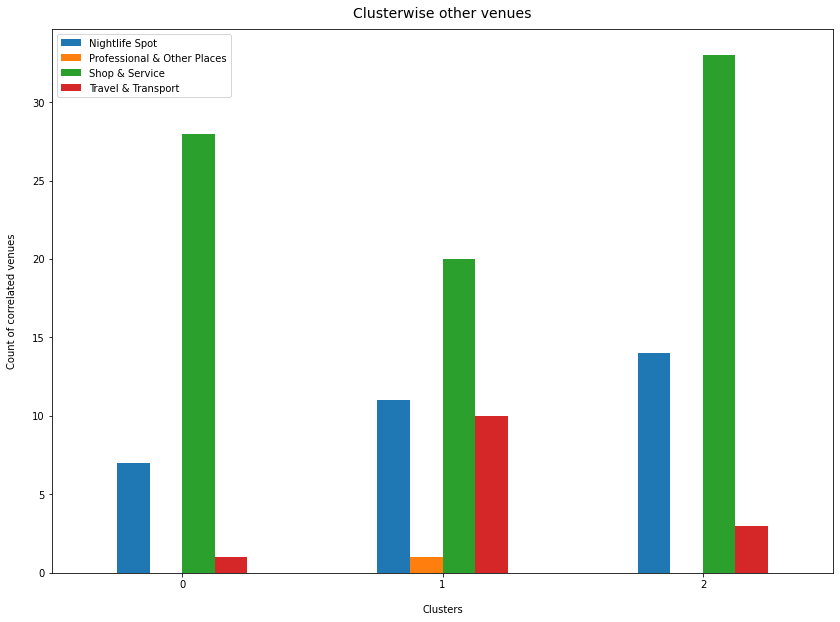

In [32]:
df_atl_cluster_1.set_index('Cluster')[['Nightlife Spot','Professional & Other Places','Shop & Service','Travel & Transport']].plot(kind='bar', figsize=(14, 10))
plt.xticks(rotation=360)
plt.title("Clusterwise other venues", fontsize=14, y=1.01)
plt.xlabel("Clusters", labelpad=15)
plt.ylabel("Count of correlated venues", labelpad=15)
plt.savefig('images/clusterwise_corr_venue_count.png')
plt.show()

#### Detailed analysis for each cluster

#####  CLUSTER 0

In [33]:
cluster_0 = df_atl_corr_venues[df_atl_corr_venues['Cluster']==0]
cluster_0 = cluster_0.drop(['Lat','Lng'], axis = 1)
cluster_0

,Neighborhood,Nightlife Spot,Professional & Other Places,Shop & Service,Travel & Transport,American Restaurant,Seafood Restaurant,Sandwich Place,Mediterranean Restaurant,Gastropub,Population,Cluster
10,North Buckhead,2,0,10,1,2.0,1.0,0.0,1.0,2.0,8270,0
11,Old Fourth Ward,0,0,2,0,0.0,0.0,0.0,0.0,0.0,10505,0
14,Virginia-Highland,5,0,16,0,1.0,0.0,0.0,0.0,0.0,7800,0


##### CLUSTER 1

In [34]:
cluster_1 = df_atl_corr_venues[df_atl_corr_venues['Cluster']==1]
cluster_1 = cluster_1.drop(['Lat','Lng'], axis = 1)
cluster_1

,Neighborhood,Nightlife Spot,Professional & Other Places,Shop & Service,Travel & Transport,American Restaurant,Seafood Restaurant,Sandwich Place,Mediterranean Restaurant,Gastropub,Population,Cluster
0,Atlanta Downtown,4,0,1,4,1.0,0.0,2.0,0.0,0.0,13411,1
9,Midtown,7,1,19,6,5.0,3.0,3.0,3.0,1.0,16569,1


##### CLUSTER 2

In [35]:
cluster_2 = df_atl_corr_venues[df_atl_corr_venues['Cluster']==2]
cluster_2 = cluster_2.drop(['Lat','Lng'], axis = 1)
cluster_2

,Neighborhood,Nightlife Spot,Professional & Other Places,Shop & Service,Travel & Transport,American Restaurant,Seafood Restaurant,Sandwich Place,Mediterranean Restaurant,Gastropub,Population,Cluster
1,Atlanta University Center,1,0,2,1,0.0,0.0,1.0,0.0,0.0,5703,2
3,East Atlanta,11,0,7,0,0.0,1.0,0.0,0.0,2.0,5033,2
4,Georgia Tech,0,0,1,0,0.0,0.0,1.0,0.0,0.0,6607,2
5,Grant Park,1,0,4,1,0.0,0.0,0.0,0.0,0.0,6771,2
6,Grove Park,0,0,3,1,0.0,1.0,0.0,0.0,0.0,4929,2
7,Home Park,1,0,4,0,0.0,0.0,2.0,1.0,0.0,4941,2
8,Kirkwood,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5897,2
12,Peachtree Heights West,0,0,12,0,0.0,0.0,1.0,0.0,0.0,4767,2
